In [ ]:
# default_exp regression_models

# regression_models

> API details.

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy.optimize import fmin
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

RANDOM_SEED = 123

## I. Regression modeling

In [ ]:
from io import StringIO

data_string = """
Drugs	Score
0	1.17	78.93
1	2.97	58.20
2	3.26	67.47
3	4.69	37.47
4	5.83	45.65
5	6.00	32.92
6	6.41	29.97
"""
#7	6.00	70.00
lsd_math = pd.read_table(StringIO(data_string), sep='\t', index_col=0)
lsd_math

,Drugs,Score
0,1.17,78.93
1,2.97,58.20
2,3.26,67.47
3,4.69,37.47
4,5.83,45.65
5,6.00,32.92
6,6.41,29.97


<AxesSubplot:xlabel='Drugs'>

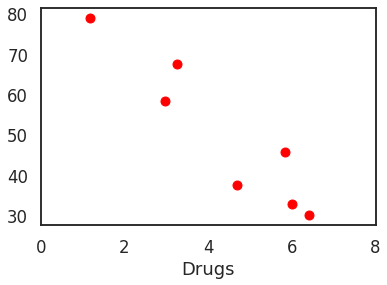

In [ ]:
# See the data
lsd_math.plot(x='Drugs',y='Score', style='ro', legend=False, xlim=(0,8))

#### Parameter estimation
the smallest sum of the squared differences between $\hat{y}$ and $y$.

$$R^2 = \sum_i (y_i - [\beta_0 + \beta_1 x_i])^2 = \sum_i \epsilon_i^2 $$

In [ ]:
# θ is the vector of β: θ = [β_0, β_1]
r_squares = lambda θ, x, y: np.sum((y - θ[0] - θ[1]*x) ** 2)

# Test
θ = [0, 0.7]
r_squares(θ, lsd_math.Drugs, lsd_math.Score)

17871.324725000006

In [ ]:
# Minimising sum of square using SciPy
x,y = lsd_math.T.values
θ = fmin(r_squares, [0,1], args=(x,y))
θ

Optimization terminated successfully.
         Current function value: 253.881329
         Iterations: 97
         Function evaluations: 179


array([89.12390921, -9.00946966])

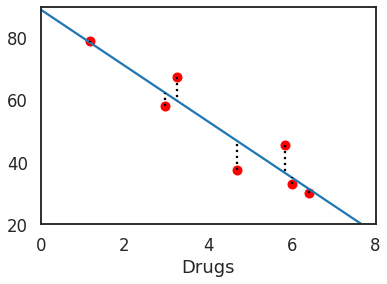

In [ ]:
# Plot the line with observations
ax = lsd_math.plot(x='Drugs', y='Score', style='ro', 
                   legend=False, xlim=(0,8), ylim=(20,90))
ax.plot([0,10], [θ[0], θ[0] + θ[1]*10])
for xi, yi in zip(x,y):
    ax.plot([xi]*2, [yi, θ[0] + θ[1]*xi], 'k:')

### Alternative loss functions

In [ ]:
sum_abs = lambda θ, x, y: np.sum(np.abs(y - θ[0] - θ[1]*x))

θ = fmin(sum_abs, [0,0], args=(x, y))
θ

Optimization terminated successfully.
         Current function value: 31.692066
         Iterations: 137
         Function evaluations: 264


array([89.86190924, -9.3435133 ])

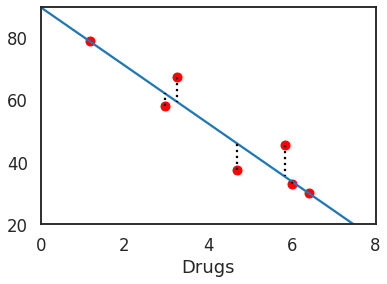

In [ ]:
# Plot the line with observations
ax = lsd_math.plot(x='Drugs', y='Score', style='ro', 
                   legend=False, xlim=(0,8), ylim=(20,90))
ax.plot([0,10], [θ[0], θ[0] + θ[1]*10])
for xi, yi in zip(x,y):
    ax.plot([xi]*2, [yi, θ[0] + θ[1]*xi], 'k:')

## II. Bayesian Linear Regression

#### Prior
$$\beta_i \sim \text{Normal}(0, 100)$$
$$\sigma \sim \text{HalfCauchy}(1)$$

(0.0, 100.0)

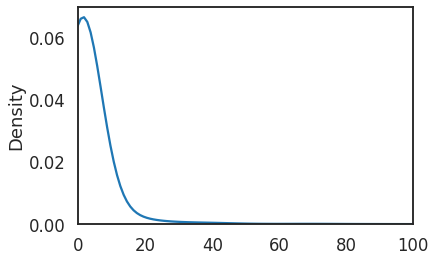

In [ ]:
from pymc3 import HalfCauchy

ax = sns.kdeplot(HalfCauchy.dist(1).random(size=10000), gridsize=2000)
ax.set_xlim(0, 100)

In [ ]:
with pm.Model() as drugs_model:
    intercept = pm.Normal('intercept', 0, sd=100)
    slope = pm.Normal('slope', 0, sd=100)
    σ = pm.HalfCauchy('σ', 1)

#### Likelihood
$$y_i \sim \text{Normal}(\mu_i, \sigma)$$

In [ ]:
with drugs_model:
    μ = intercept + slope*x
    score = pm.Normal('score', μ, sd=σ, observed=y)

In [ ]:
with drugs_model:
    drug_samples = pm.sample(1000, random_seed=RANDOM_SEED)

<ipython-input-67-52c55f3a4407>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  drug_samples = pm.sample(1000, random_seed=RANDOM_SEED)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, slope, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7184787464697843, but should be close to 0.8. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


/opt/conda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'intercept'}>,
       <AxesSubplot:title={'center':'slope'}>,
       <AxesSubplot:title={'center':'σ'}>], dtype=object)

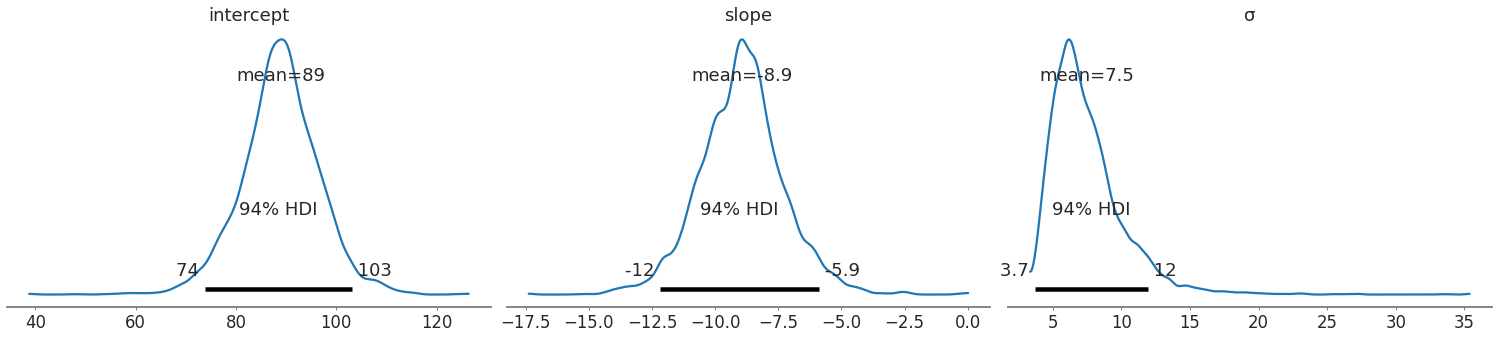

In [ ]:
pm.plot_posterior(drug_samples)

#### Checking model fit


In [ ]:
with drugs_model:
    drugs_ppc = pm.sample_posterior_predictive(drug_samples, 1000)

/opt/conda/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [ ]:
drugs_ppc['score'].shape

(1000, 7)

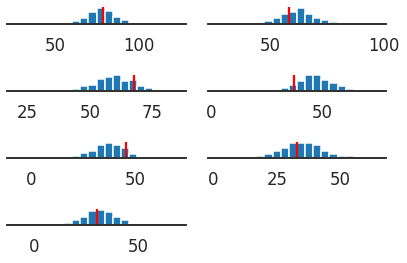

In [ ]:
fig, axes = plt.subplots(4, 2)
axes_flat = axes.flatten()

for ax, real_data, sim_data in zip(axes_flat[:-1], y, drugs_ppc['score'].T):
    ax.hist(sim_data, bins=20)
    ax.vlines(real_data, *ax.get_ylim(), colors='red')
    ax.set_yticklabels([])
    sns.despine(left=True)

axes_flat[-1].axis('off')
plt.tight_layout()